# Librerias 

In [1]:
import numpy as np 
import pandas as pd 
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Conv2DTranspose, Reshape, BatchNormalization, Dropout
from keras.metrics import categorical_accuracy
from tensorflow.keras.losses import Loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from tensorflow.keras import layers, regularizers

2024-08-07 22:17:45.790983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 22:17:45.791075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 22:17:45.925758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Base de datos 

A la base de datos mnist, se le realiza una normalización dividiendo por 255 pixeles y se realiza la partición de los datos.

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
X_train.shape

(55000, 28, 28)

# Funciones para graficar

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Clase de BinaryCrossentropy

In [4]:
class ScaledBinaryCrossentropy:
    def __init__(self, scale=1.0):
        """
        Inicializa la clase de pérdida personalizada.
        :param scale: float, el factor de escala para la pérdida.
        :param name: str, nombre de la pérdida.
        """

        self.scale = scale

    def __call__(self, y_true, y_pred):
        """
        Calcula la pérdida escalada.
        :param y_true: Tensor, etiquetas verdaderas.
        :param y_pred: Tensor, predicciones del modelo.
        :return: Tensor, pérdida escalada.
        """
        # Calcula la binary crossentropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Retorna la binary crossentropy escalada
        return self.scale * bce

# Clase del VAE

In [5]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, alpha=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        kl_loss = self.alpha * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * .5) + z_mean

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# 2. Autoencoder AE

Un autoencoder es una red neuronal que intenta aprender una representación (codificación) eficiente de los datos de entrada, típicamente para la reducción de dimensionalidad o para la reconstrucción de datos, se compone de codificador y decodificador:

* Codificador: Mapea la entrada a una representación de menor dimensión (latente).
* Decodificador: Reconstruye la entrada original a partir de la representación latente.

Objetivo:
Minimizar la diferencia entre la entrada original y la salida reconstruida, normalmente utilizando la pérdida de reconstrucción, como el error cuadrático medio (MSE) o la entropía cruzada binaria.

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

input_img = keras.layers.Input(shape=[28, 28])

# Codificador
x = keras.layers.Flatten()(input_img)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(700, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(500, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
encoded = keras.layers.Dense(400, activation="relu")(x)

# Decodificador
x = keras.layers.Dense(700, activation="relu")(encoded)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(500, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
decoded = keras.layers.Reshape([28, 28])(x)

# Crear el autoencoder 
stacked_ae = keras.models.Model(input_img, decoded)

# Compilar el modelo
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=5e-1), 
                   metrics=[rounded_accuracy])

history = stacked_ae.fit(X_train, X_train, epochs=100, batch_size=32,verbose=2,
                         validation_data=(X_valid, X_valid))

Epoch 1/100


I0000 00:00:1723069117.745472     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723069117.765385     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723069123.564471     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1719/1719 - 10s - 6ms/step - loss: 0.4054 - rounded_accuracy: 0.8640 - val_loss: 0.3127 - val_rounded_accuracy: 0.9134
Epoch 2/100
1719/1719 - 4s - 2ms/step - loss: 0.3126 - rounded_accuracy: 0.9091 - val_loss: 0.2987 - val_rounded_accuracy: 0.9229
Epoch 3/100
1719/1719 - 4s - 2ms/step - loss: 0.3026 - rounded_accuracy: 0.9167 - val_loss: 0.2921 - val_rounded_accuracy: 0.9283
Epoch 4/100
1719/1719 - 5s - 3ms/step - loss: 0.2967 - rounded_accuracy: 0.9216 - val_loss: 0.2878 - val_rounded_accuracy: 0.9320
Epoch 5/100
1719/1719 - 4s - 2ms/step - loss: 0.2926 - rounded_accuracy: 0.9252 - val_loss: 0.2849 - val_rounded_accuracy: 0.9347
Epoch 6/100
1719/1719 - 4s - 2ms/step - loss: 0.2896 - rounded_accuracy: 0.9279 - val_loss: 0.2827 - val_rounded_accuracy: 0.9367
Epoch 7/100
1719/1719 - 4s - 2ms/step - loss: 0.2872 - rounded_accuracy: 0.9301 - val_loss: 0.2809 - val_rounded_accuracy: 0.9384
Epoch 8/100
1719/1719 - 4s - 2ms/step - loss: 0.2853 - rounded_accuracy: 0.9320 - val_loss: 0.2794 - 

# Loss

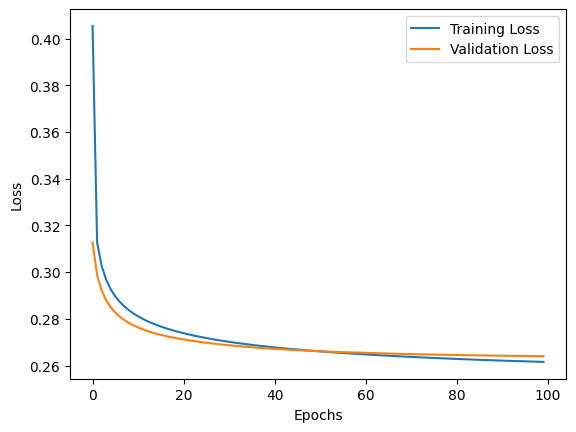

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy

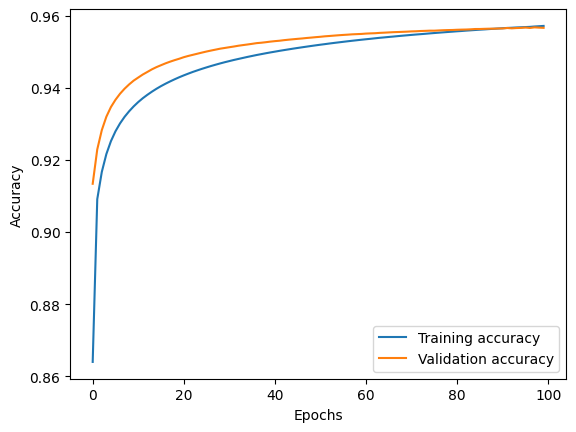

In [8]:
plt.plot(history.history['rounded_accuracy'], label='Training accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Reconstrucción

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


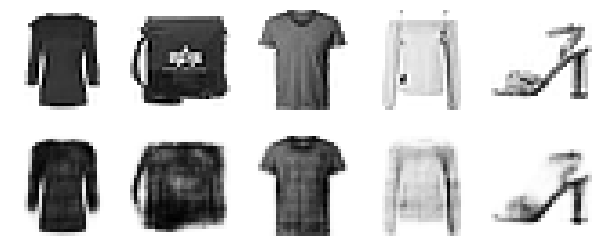

In [9]:
show_reconstructions(stacked_ae)
plt.show()

# 2.1 Autoencoder Regularizado

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Flatten(),
    keras.layers.Dense(400, activation="selu")
])


stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, activation="selu", input_shape=[400]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid", kernel_regularizer=regularizers.l1(0.001)),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])


stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[rounded_accuracy])


history = stacked_ae.fit(X_train, X_train, epochs=100, batch_size=64,
                         validation_data=(X_valid, X_valid))

Epoch 1/100
 16/860 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 5.8727 - rounded_accuracy: 0.6978 

W0000 00:00:1723078474.111040     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723078474.113863     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


860/860 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1207 - rounded_accuracy: 0.8867

W0000 00:00:1723078483.657354     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723078483.659878     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723078484.778632     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


860/860 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 1.1200 - rounded_accuracy: 0.8867 - val_loss: 0.3368 - val_rounded_accuracy: 0.9181
Epoch 2/100
 22/860 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.3369 - rounded_accuracy: 0.9195

W0000 00:00:1723078485.765317     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3300 - rounded_accuracy: 0.9252 - val_loss: 0.3254 - val_rounded_accuracy: 0.9298
Epoch 3/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3223 - rounded_accuracy: 0.9311 - val_loss: 0.3213 - val_rounded_accuracy: 0.9331
Epoch 4/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.3187 - rounded_accuracy: 0.9339 - val_loss: 0.3189 - val_rounded_accuracy: 0.9347
Epoch 5/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.3166 - rounded_accuracy: 0.9357 - val_loss: 0.3172 - val_rounded_accuracy: 0.9363
Epoch 6/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3149 - rounded_accuracy: 0.9373 - val_loss: 0.3157 - val_rounded_accuracy: 0.9381
Epoch 7/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3134 - rounded_accuracy: 0.9388 - val_loss: 0.3145 - val_rounded_accuracy: 0.9387
Epoch 8/100
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.3123 - rounded_accuracy: 0.9395 - val_loss: 0.3136 - val_rounded_accuracy: 0.93

# Caida del loss

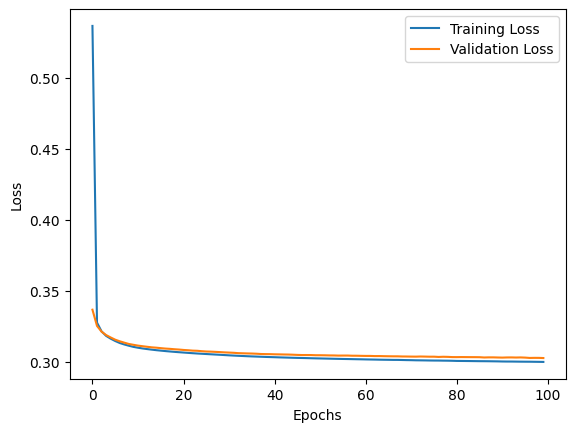

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

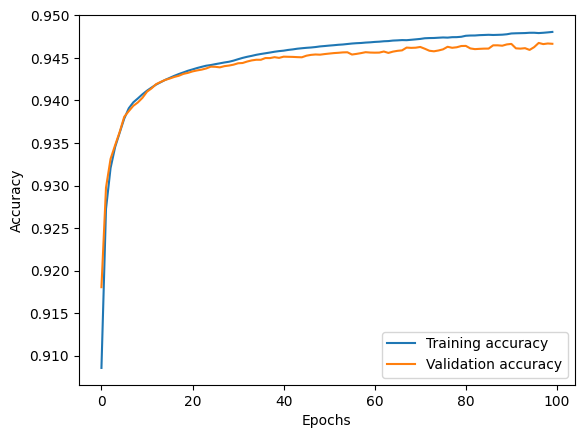

In [34]:
plt.plot(history.history['rounded_accuracy'], label='Training accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Reconstrucción

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


W0000 00:00:1723081212.630796     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


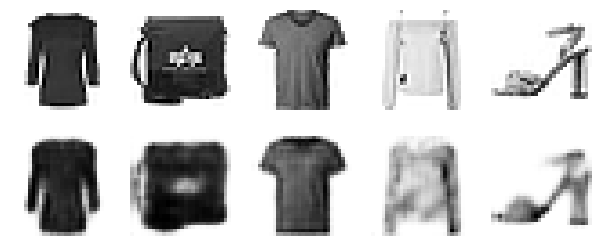

In [35]:
show_reconstructions(stacked_ae)
plt.show()

# 2.1.1 Autoencoder Variacional VAE

(Encoder):

* El codificador toma una entrada $(x)$ y la mapea a una distribución latente $(z)$. En lugar de mapear directamente a un punto en el espacio latente, el codificador genera parámetros de una distribución, típicamente la media $(\mu)$ y la desviación estándar $(\sigma)$ de una distribución normal.

* El objetivo del codificador es aprender a representar la entrada en un espacio latente donde las relaciones entre las variables de entrada se mantengan.

* Durante el entrenamiento, se extrae una muestra del espacio latente utilizando la reparametrización de truco para permitir el cálculo de gradientes y la retropropagación. Esto se hace mediante $(z = \mu + \sigma \cdot \epsilon)$, donde $(\epsilon)$ es un ruido gaussiano.



In [73]:
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='selu', strides=2, padding='same')(encoder_inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='selu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='selu')(x)
    x = Dropout(0.3)(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

def build_decoder(latent_dim):
    decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(7*7*64, activation='selu')(decoder_inputs)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='selu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='selu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder


In [74]:
latent_dim = 256
alpha = 0.2
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

vae = VAE(encoder, decoder, alpha=alpha)
beta= 1-alpha
loss2=ScaledBinaryCrossentropy(beta)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy]) 
history = vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

Epoch 1/100
  34/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.5025 - rounded_accuracy: 0.6730

W0000 00:00:1723085624.048915     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3470 - rounded_accuracy: 0.8304

W0000 00:00:1723085631.373287     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723085631.376729     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723085632.952680     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.3470 - rounded_accuracy: 0.8305 - val_loss: 0.2884 - val_rounded_accuracy: 0.8891
Epoch 2/100
  40/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2888 - rounded_accuracy: 0.8868

W0000 00:00:1723085634.335360     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2839 - rounded_accuracy: 0.8921 - val_loss: 0.2727 - val_rounded_accuracy: 0.9027
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2702 - rounded_accuracy: 0.9031 - val_loss: 0.2654 - val_rounded_accuracy: 0.9083
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2638 - rounded_accuracy: 0.9082 - val_loss: 0.2639 - val_rounded_accuracy: 0.9106
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2611 - rounded_accuracy: 0.9107 - val_loss: 0.2606 - val_rounded_accuracy: 0.9136
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2592 - rounded_accuracy: 0.9125 - val_loss: 0.2597 - val_rounded_accuracy: 0.9128
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2578 - rounded_accuracy: 0.9138 - val_loss: 0.2591 - val_rounded_accuracy: 0.9127
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2569 - rounded_accuracy: 0.9148 - val_loss: 0.2576 - val_rounded

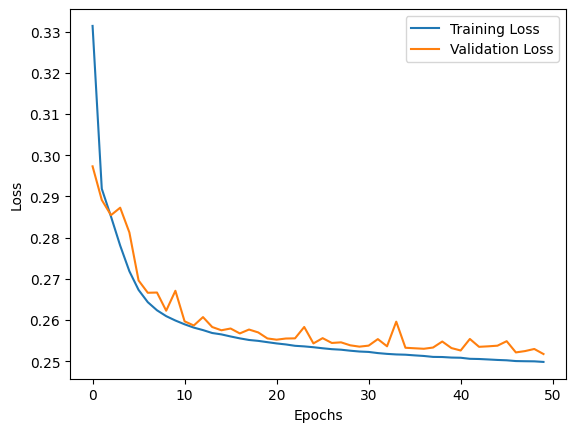

In [63]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

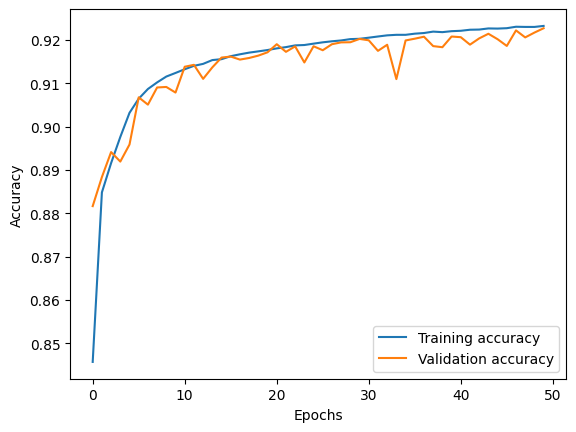

In [64]:
plt.plot(history.history['rounded_accuracy'], label='Training accuracy')
plt.plot(history.history['val_rounded_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


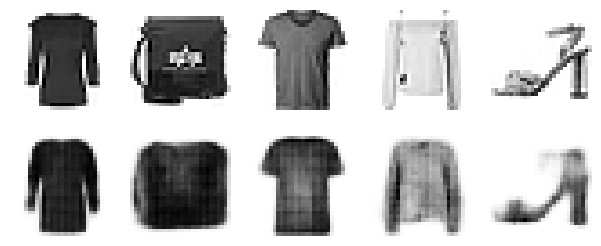

In [72]:
show_reconstructions(vae)
plt.show()

# PCA y TSNE

106/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1723081966.244876     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


W0000 00:00:1723081967.366767     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


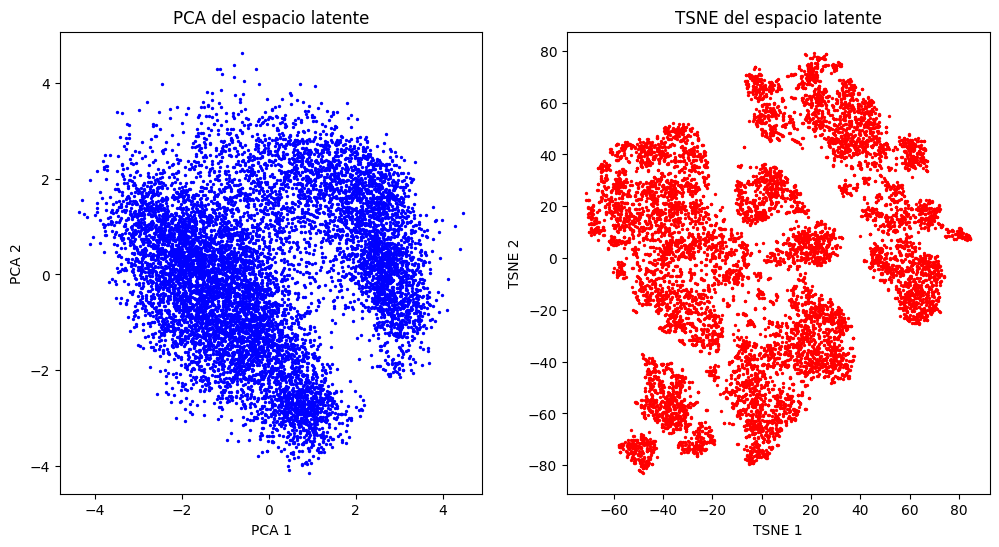

In [41]:
z_mean, _ = vae.encoder.predict(X_test)
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z_mean)

plt.figure(figsize=(12, 6))

# PCA
plt.subplot(1, 2, 1)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c='blue', s=2)
plt.title('PCA del espacio latente')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# TSNE
plt.subplot(1, 2, 2)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='red', s=2)
plt.title('TSNE del espacio latente')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

plt.show()